## 导入包，读入数据集

In [196]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [197]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

((891, 12), (418, 11))

## 数据预处理

In [198]:
y = np.array(train['Survived'])
train = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

all_features = pd.concat([train, test])
all_features.Sex = all_features.Sex.map({'male':0,'female':1})  #male变成0，female变成1
all_features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,S
1,1,1,38.0,1,0,71.2833,C
2,3,1,26.0,0,0,7.9250,S
3,1,1,35.0,1,0,53.1000,S
4,3,0,35.0,0,0,8.0500,S


In [199]:
# 对数值列做normalization
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std()
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features[numeric_features]

,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.841595,-0.743213,-0.546789,0.481104,-0.444829,-0.503210
1,-1.545507,1.344482,0.563282,0.481104,-0.444829,0.733941
2,0.841595,1.344482,-0.269271,-0.478904,-0.444829,-0.490169
3,-1.545507,1.344482,0.355144,0.481104,-0.444829,0.382632
4,0.841595,-0.743213,0.355144,-0.478904,-0.444829,-0.487754
...,...,...,...,...,...,...
413,0.841595,-0.743213,0.000000,-0.478904,-0.444829,-0.487754
414,-1.545507,1.344482,0.632662,-0.478904,-0.444829,1.460712
415,0.841595,-0.743213,0.597972,-0.478904,-0.444829,-0.503210
416,0.841595,-0.743213,0.000000,-0.478904,-0.444829,-0.487754


处理离散值，One-Hot Encode

In [200]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features[:5]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.841595,-0.743213,-0.546789,0.481104,-0.444829,-0.503210,0,0,1,0
1,-1.545507,1.344482,0.563282,0.481104,-0.444829,0.733941,1,0,0,0
2,0.841595,1.344482,-0.269271,-0.478904,-0.444829,-0.490169,0,0,1,0
3,-1.545507,1.344482,0.355144,0.481104,-0.444829,0.382632,0,0,1,0
4,0.841595,-0.743213,0.355144,-0.478904,-0.444829,-0.487754,0,0,1,0


通过values属性，将值提出来，转成张量

In [201]:
n_train = train.shape[0]
# n_valid = len(train) - n_train

train_labels = torch.tensor(y[:round(n_train * 0.8)], dtype=torch.long)
valid_labels = torch.tensor(y[round(n_train * 0.8):], dtype=torch.long)

train_features = torch.tensor(all_features[:round(n_train * 0.8)].values, dtype=torch.float32)
valid_features = torch.tensor(all_features[round(n_train * 0.8):n_train].values, dtype=torch.float32)

test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

print(f'training set: {train_features.shape}, \nvalidation set: {valid_features.shape}, \ntest set: {test_features.shape}\n')
print(train_labels.shape, valid_labels.shape)

training set: torch.Size([713, 10]), 
validation set: torch.Size([178, 10]), 
test set: torch.Size([418, 10])

torch.Size([713]) torch.Size([178])


In [202]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        Y = self.y[index]
        return X, Y

In [203]:
batch_size = 256
train_set = MyDataset(train_features, train_labels)
valid_set = MyDataset(valid_features, valid_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

## 定义模型

In [204]:
loss = nn.CrossEntropyLoss()
in_features = train_features.shape[1]

# binary classification
model = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 96),
    nn.ReLU(),
    nn.Linear(96, 96),
    nn.ReLU(),
    nn.Linear(96, 96),
    nn.ReLU(),
    nn.Linear(96, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
)

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
model.apply(init_weight)

Sequential(
  (0): Linear(in_features=10, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=96, bias=True)
  (3): ReLU()
  (4): Linear(in_features=96, out_features=96, bias=True)
  (5): ReLU()
  (6): Linear(in_features=96, out_features=96, bias=True)
  (7): ReLU()
  (8): Linear(in_features=96, out_features=64, bias=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=2, bias=True)
)

In [205]:
def train(model, num_epochs, lr, weight_decay):
    train_ls, valid_ls = [], []
    optimzer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for i, data in enumerate(train_loader):
            optimzer.zero_grad()
            y_hat = model(data[0])
            y = data[1]
            # print(y_hat.shape, y.shape)
            # print(loss(y_hat, y).item())
            batch_loss = loss(y_hat, y)
            batch_loss.backward()
            optimzer.step()
            train_loss += batch_loss.item()

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                y_hat = model(data[0])
                y = data[1]
                valid_loss += batch_loss.item()
            
            train_ls.append(train_loss/train_set.__len__())
            valid_ls.append(valid_loss/valid_set.__len__())
            #將結果 print 出來
            # print(f'[{epoch+1}/{num_epochs}] average train loss: {train_loss/train_set.__len__()} | average valid loss: {valid_loss/valid_set.__len__()}')
    
    return train_ls, valid_ls

## k-fold corss validation

## 训练

0.0018806602142301884 
 0.0026564102494314817


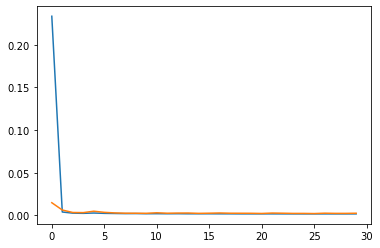

In [206]:
k, num_epochs, lr, weight_decay = 5, 30, 0.1, 0
train_ls, valid_ls = train(model, num_epochs, lr, weight_decay)
plt.plot(range(len(train_ls)), train_ls, valid_ls)
print(f'{train_ls[-1]} \n {valid_ls[-1]}')
# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

In [207]:
def accuracy(y_hat, y):
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

print(accuracy(model(train_features), train_labels) / len(train_labels))
print(accuracy(model(valid_features), valid_labels) / len(valid_labels))

0.8190743338008415
0.8089887640449438


将全部数据对模型进行二次训练

0.0021347700295575372
0.8507295173961841


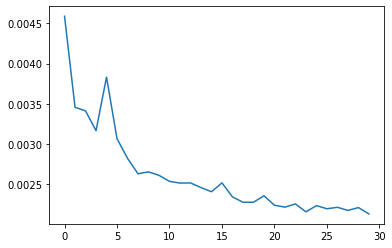

In [208]:
X = np.concatenate((train_features, valid_features), axis=0)
Y = np.concatenate((train_labels, valid_labels), axis=0)
all_set = MyDataset(X, Y)
all_loader = DataLoader(all_set, batch_size=batch_size, shuffle=True)

def train(model, num_epochs, lr, weight_decay):
    train_ls = []
    optimzer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        train_loss = 0.0
        for i, data in enumerate(all_loader):
            optimzer.zero_grad()
            y_hat = model(data[0])
            y = data[1]
            batch_loss = loss(y_hat, y)
            batch_loss.backward()
            optimzer.step()
            train_loss += batch_loss.item()
        train_ls.append(train_loss/train_set.__len__())
    return train_ls

# X.shape, Y.shape
num_epochs, lr, weight_decay = 30, 0.1, 0
train_ls = train(model, num_epochs, lr, weight_decay)
plt.plot(range(len(train_ls)), train_ls)
print(f'{train_ls[-1]}')
print(accuracy(model(torch.tensor(X)), torch.tensor(Y)) / len(Y))

## 预测

In [209]:
test_loader = DataLoader(test_features, batch_size=batch_size, shuffle=False)
model.eval()
prediction = []
with torch.no_grad():
  for i, data in enumerate(test_loader):
    test_pred = model(data)
    test_label = np.argmax(test_pred.data.numpy(), axis=1)
    for y in test_label:
      prediction.append(y)

In [210]:
# 结果写入csv
with open('prediction.csv', 'w') as f:
  f.write('PassengerId,Survived\n')
  for i, y in enumerate(prediction):
    f.write('{},{}\n'.format(i+892, y))